In [1]:
# GEO prefix implies geo_env (geopandas/arcgis enabled)
# https://geopandas.org/install.html#creating-a-new-environment
! echo $CONDA_DEFAULT_ENV

geo_env


In [74]:
# geo imports
import fiona
import geopandas as gpd

In [2]:
# standard imports
import sys
import getpass
user = getpass.getuser()
sys.dont_write_bytecode = True
sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))
from utils_io import *

In [92]:
# plot imports
import contextily as ctx
import matplotlib.pyplot as plt

# RHNA Site Selection Pre-Screening Dataset Processing <a name="top"></a>

## Approach

Develop a parcel-level dataset containing factors required by HCD as well as optional factors such as whether the site is located within a high opportunity area, or a transportation priority area, any floor area ratio requirements of the site, etc. The dataset will be developed from a combination of publically available datasets as well as datasets developed by MTC/ABAG from local governments and counties throughout the Bay Area.

## Data Sources

**[Data Sources Inventory](https://mtcdrive.app.box.com/file/700718735166)**

## Table of Contents

1. [Pre-Processing Step](#preprocessing)
2. [Step 4: Process **opportunity** datasets](#opportunity)
    1. [Process TCAC/HCD Resource Opportunity Areas 2020](#roa)
    2. [Process HUD Fair Market Rents](#fmr)
3. [Step 5: Process **accessibility** datasets](#accessibility)
    1. [Process Transit Rich Areas](#tra)
    2. [Process Travel Model I VMT](#vmt)
4. [Step 6: Process **environment** datasets](#environment)
    1. [Process California Protected Area Database](#cpad)
    2. [Process Fire Severity Risk: State and Local Responsibility Areas](#fsr)
    3. [Process BCDC Sea Level Rise Inundation](#slr)
5. [Step 7: Process **planning** datasets](#planning)
    1. [Process Priority Development Areas](#pda)
    2. [Process Prior RHNA Sites](#rhna)
    3. [Process Zoning](#zoning)
    4. [Process General Plan](#generalplan)

## Pre-Processing Step <a name="preprocessing"></a>
- This notebook is intented to support the overlay processing work to create the full housing element site selection dataset. Most of this work will not take place in one session so this pre-processing step is meant to be run before proceeding with steps below.  

**[Skip to next step](#opportunity)**

In [155]:
# Box working directory path
data_dir = os.path.join('/Users',
                        user,
                        'Box',
                        'DataViz Projects',
                        'Data Analysis and Visualization',
                        'Housing Element Site Mapping and Pre-screening',
                        'data')

### Pull [Housing Element Site Selection Parcels](https://data.bayareametro.gov/Land-People/Housing-Element-Site-Selection-Parcels/j9hp-a3zr)

In [6]:
# Socrata housing site selection db 4x4
housing_site_db_id = 'j9hp-a3zr'  # d8wd-vg4y

In [9]:
#Pull housing site selection parcels from Socrata
parcels_geojson = pull_geojson_from_socrata(housing_site_db_id)

pulling 2142677 rows as geojson


In [12]:
# Convert to geojson to geodataframe
parcels = gpd.GeoDataFrame.from_features(parcels_geojson['features'],
                                         crs='EPSG:4326')

In [13]:
parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2142677 entries, 0 to 2142676
Data columns (total 32 columns):
 #   Column      Dtype   
---  ------      -----   
 0   geometry    geometry
 1   rhna_4      object  
 2   fmr_3bdr    object  
 3   acres       object  
 4   geom_id     object  
 5   vmt         object  
 6   sea_level   object  
 7   plu_gp      object  
 8   tra         object  
 9   fmr_4bdr    object  
 10  urban_serv  object  
 11  rsrc_level  object  
 12  fmr_0bdr    object  
 13  centroid_y  object  
 14  fire_risk   object  
 15  county      object  
 16  exist_lu    object  
 17  fmr_4plbdr  object  
 18  jurisdict   object  
 19  centroid_x  object  
 20  fmr_2bdr    object  
 21  fire_autho  object  
 22  fmr_1bdr    object  
 23  parcel_id   object  
 24  trct_geoid  object  
 25  plu_zoning  object  
 26  apn         object  
 27  rhna_5      object  
 28  bldg_permt  object  
 29  blkg_geoid  object  
 30  public_own  object  
 31  cpad        obje

In [14]:
#Convert centroid columns to float data type
parcels['centroid_x'] = parcels['centroid_x'].astype(float)
parcels['centroid_y'] = parcels['centroid_y'].astype(float)

In [16]:
#Create parcel centroid geodataframe
parcels_centroid = gpd.GeoDataFrame(parcels,
                                   geometry=gpd.points_from_xy(parcels['centroid_x'],
                                                             parcels['centroid_y']),
                                   crs='EPSG:4326')

parcels_centroid.head(5)

,geometry,rhna_4,fmr_3bdr,acres,geom_id,vmt,sea_level,plu_gp,tra,fmr_4bdr,...,fmr_1bdr,parcel_id,trct_geoid,plu_zoning,apn,rhna_5,bldg_permt,blkg_geoid,public_own,cpad
0,POINT (-122.33544 37.98419),None,None,0.014507214240153,5444677669878114970,None,None,None,None,None,...,None,CC208679,06013365003,None,405520022,None,None,060133650031,None,None
1,POINT (-121.99306 37.22761),None,None,0.16061245152327,N4044063777024811420,None,None,None,None,None,...,None,SC247811,06085507001,None,51040146,None,None,060855070012,None,None
2,POINT (-121.81830 37.25810),None,None,0.210733707033247,2265894416468866674,None,None,None,None,None,...,None,SC412297,06085512022,None,69011039,None,None,060855120221,None,None
3,POINT (-122.03819 37.31797),None,None,0.176850694083858,3935937022401185163,None,None,None,None,None,...,None,SC037475,06085507701,None,35914044,None,None,060855077013,None,None
4,POINT (-122.36061 37.58385),None,None,0.0917729735371208,N3788479476165547265,None,None,None,None,None,...,None,SM079992,06081605300,None,026221230,None,None,060816053001,None,None


**[Back to Top](#top)**

**[Back to previous section](#preprocessing)**

**[Skip to next section](#accessibility)**

## Step 4: Process opportunity datasets <a name="opportunity"></a>

#### [A. TCAC/HCD Resource Opportunity Areas 2020](#roa)

- TCAC/HCD Resource Opportunity Area data was last updated in early 2020. 
- TCAC/HCD Resource Opportunity Area dataset contains data for the entire Bay Area by census tract and block group. 
- Columns from this dataset that will be associated with parcels include:
    - Final Category
    
- To associate these data with parcels, we will use a two-step join operation. 
    - 1st join: join tract-level data to parcels using the tract geoid added to the framework dataset in earlier steps. This will be an 'inner' join as we only care about the matching records. 
    - 2nd join: join block group-level data to parcels using the block geoid added to the framework dataset in earlier steps. This will be an 'inner' join as we again only care about matching records. 
    - Blocks and Tracts were added to the framework dataset using a point in polygon method. 
    - Urban Areas provide data at the tract level while rural area data were provided at the block group level.
    
Resulting field added: **reso_level**

#### [B. HUD Fair Market Rents](#fmr)

- Fair Market Rents (FMRs) data was last updated in 2019.
- Fair Market Rents (FMRs) are used to determine payment standard amounts for the Housing Choice Voucher program, to determine initial renewal rents for some expiring project-based Section 8 contracts, to determine initial rents for housing assistance payment (HAP) contracts in the Moderate Rehabilitation Single Room Occupancy program (Mod Rehab), rent ceilings for rental units in both the HOME Investment Partnerships program and the Emergency Solution Grants program, calculation of maximum award amounts for Continuum of Care recipients and the maximum amount of rent a recipient may pay for property leased with Continuum of Care funds, and calculation of flat rents in Public Housing units. 
- The U.S. Department of Housing and Urban Development (HUD) annually estimates FMRs for Office of Management and Budget (OMB) defined metropolitan areas, some HUD defined subdivisions of OMB metropolitan areas and each nonmetropolitan county. 42 USC 1437f requires FMRs be posted at least 30 days before they are effective and that they are effective at the start of the federal fiscal year (generally October 1).

- Columns from this dataset that will be associated with parcels include: 
    - 0 Bedroom Fair Market Rent
    - 1 Bedroom Fair Market Rent
    - 2 Bedroom Fair Market Rent
    - 3 Bedroom Fair Market Rent
    - 4 Bedroom Fair Market Rent
    - 4 Plus Bedroom Fair Market Rent
    
Resulting fields added:

- **fmr_0bdr**
- **fmr_1bdr**
- **fmr_2bdr**
- **fmr_3bdr**
- **fmr_4bdr**
- **fmr_4plbdr**

**[Back to Top](#top)**

**[Back to Section Top](#opportunity)**

### 4A. Process TCAC/HCD Resource Opportunity Areas 2020 <a name="roa"></a>

Result of this step: Add **reso_level** field to Socrata dataset

**[Skip to next step](#fmr)**

In [17]:
os.listdir(data_dir)

['CalEnviroStore',
 'geojson',
 'Potential_data_sources.xlsx',
 'site_selection_prescreening_database.gdb',
 'tabular']

In [21]:
os.listdir(os.path.join(data_dir, 'tabular'))

['ctcac_hcd_final_2020_public.xlsx']

In [38]:
#Read in 2020 TCAC/HCD Resource Opportunity Areas
resource_areas_path = 'ctcac_hcd_final_2020_public.xlsx'
resource_areas_path = os.path.join(data_dir,
                                   'tabular',
                                   resource_areas_path)

resource_areas = pd.read_excel(resource_areas_path,
                               dtype={'Census Tract':str,
                                      'Census Block Group':str}
                              )

#Inspect resource areas
resource_areas.head(5)

,Census Tract,Census Block Group,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,06001400100,NaN,Alameda,6001.0,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,6001.0,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,6001.0,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,6001.0,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,6001.0,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [22]:
#Return info about resource areas
resource_areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10144 entries, 0 to 10143
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Census Tract                            10144 non-null  object 
 1   Census Block Group                      3093 non-null   object 
 2   County                                  10144 non-null  object 
 3   County ID                               10143 non-null  float64
 4   Region                                  10144 non-null  object 
 5   Economic Domain Score (by region)       9635 non-null   float64
 6   Environmental Domain Score (by region)  9635 non-null   float64
 7   Education Domain Score (by region)      9635 non-null   float64
 8   Composite Index Score                   8786 non-null   float64
 9   Final Category                          9635 non-null   object 
dtypes: float64(5), object(5)
memory usage: 792.6+ KB


In [24]:
resource_areas['Final Category'].unique()

# array(['High Resource', 'Highest Resource',
#        'Moderate Resource (Rapidly Changing)', 'Moderate Resource',
#        'Low Resource', 'High Segregation & Poverty', nan], dtype=object)

array(['High Resource', 'Highest Resource',
       'Moderate Resource (Rapidly Changing)', 'Moderate Resource',
       'Low Resource', 'High Segregation & Poverty', nan], dtype=object)

In [25]:
resource_areas['Region'].unique()

array(['Bay Area Region', 'Capital Region', 'Central Valley Region',
       'Inland Empire Region', 'Los Angeles Region',
       'Central Coast Region', 'Orange County Region', 'San Diego Region',
       'Rural Areas'], dtype=object)

In [23]:
resource_areas[resource_areas['Region'] == 'Bay Area Region'].shape  # (1513, 10)

(1513, 10)

In [40]:
# rename columns
rename_d = {'Census Tract': 'trct_geoid',
            'Census Block Group': 'blkg_geoid',
            'Final Category': 'reso_level'}

resource_areas = resource_areas.rename(columns=rename_d)

In [41]:
# subset resource areas at the tract level geography
filter_str = "trct_geoid.notnull() & Region == 'Bay Area Region'"
resource_tracts = resource_areas.query(filter_str, engine='python')
print(len(resource_tracts))  # 1513

1513


In [61]:
ra_parcels = pd.merge(parcels[['parcel_id','trct_geoid']],
                      resource_tracts[['trct_geoid','reso_level']])

In [62]:
ra_parcels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1982500 entries, 0 to 1982499
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   parcel_id   object
 1   trct_geoid  object
 2   reso_level  object
dtypes: object(3)
memory usage: 60.5+ MB


In [63]:
ra_parcels.head()

,parcel_id,trct_geoid,reso_level
0,CC208679,06013365003,Low Resource
1,CC203339,06013365003,Low Resource
2,CC199983,06013365003,Low Resource
3,CC207761,06013365003,Low Resource
4,CC209189,06013365003,Low Resource


In [43]:
# subset rural area block groups
filter_str = "blkg_geoid.notnull() & Region == 'Rural Areas'"
ra_blkgp = resource_areas.query(filter_str, engine='python')
print(len(ra_blkgp))  # 3093
ra_blkgp.head()

3093


,trct_geoid,blkg_geoid,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,reso_level
7051,06003010000,060030100001,Alpine,6003.0,Rural Areas,NaN,NaN,NaN,NaN,NaN
7052,06003010000,060030100002,Alpine,6003.0,Rural Areas,NaN,NaN,NaN,NaN,NaN
7053,06005000101,060050001011,Amador,6005.0,Rural Areas,0.192,0.885,0.115,-0.163,Moderate Resource
7054,06005000101,060050001012,Amador,6005.0,Rural Areas,0.115,0.885,0.115,-0.170,Low Resource
7055,06005000101,060050001013,Amador,6005.0,Rural Areas,0.077,0.885,0.115,-0.271,Low Resource


In [46]:
# Join to parcels
ra_parcel_blkgp = pd.merge(parcels[['parcel_id','blkg_geoid']],
                           ra_blkgp[['blkg_geoid','reso_level']])

In [47]:
ra_parcel_blkgp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158444 entries, 0 to 158443
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   parcel_id   158444 non-null  object
 1   blkg_geoid  158444 non-null  object
 2   reso_level  156404 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB


In [48]:
ra_parcel_blkgp.head()

,parcel_id,blkg_geoid,reso_level
0,MA092602,060411321002,Highest Resource
1,MA093285,060411321002,Highest Resource
2,MA093472,060411321002,Highest Resource
3,MA093420,060411321002,Highest Resource
4,MA093629,060411321002,Highest Resource


### Combine tract and block group dfs to create complete parcel resource area correspondence

In [67]:
ra_parcels = ra_parcels.append(ra_parcel_blkgp)
ra_parcels.head()

,parcel_id,trct_geoid,reso_level,blkg_geoid
0,CC208679,06013365003,Low Resource,NaN
1,CC203339,06013365003,Low Resource,NaN
2,CC199983,06013365003,Low Resource,NaN
3,CC207761,06013365003,Low Resource,NaN
4,CC209189,06013365003,Low Resource,NaN


In [68]:
ra_parcels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140944 entries, 0 to 158443
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   parcel_id   object
 1   trct_geoid  object
 2   reso_level  object
 3   blkg_geoid  object
dtypes: object(4)
memory usage: 81.7+ MB


In [70]:
print(len(ra_parcels[ra_parcels['blkg_geoid'].notnull()]))  # 158444
ra_parcels[ra_parcels['blkg_geoid'].notnull()].head()

158444


,parcel_id,trct_geoid,reso_level,blkg_geoid
0,MA092602,NaN,Highest Resource,060411321002
1,MA093285,NaN,Highest Resource,060411321002
2,MA093472,NaN,Highest Resource,060411321002
3,MA093420,NaN,Highest Resource,060411321002
4,MA093629,NaN,Highest Resource,060411321002


### Upsert to socrata

Resulting field added: **reso_level**

In [44]:
upsert_df = ra_parcels[['parcel_id','reso_level']]

upsert_df_socrata(upsert_df,
                  housing_site_db_id,
                  chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 8.7237 minutes


**[Back to Top](#top)**

**[Back to Section Top](#opportunity)**

### 4B. Process HUD Fair Market Rents <a name="fmr"></a>

Result of this step: Add **fmr_{1-4}bdr**, **fmr_4plbdr** fields to Socrata dataset

**[Back to previous step](#roa)**

**[Skip to next section](#accessibility)**

In [72]:
os.listdir(data_dir)

['CalEnviroStore',
 'geojson',
 'Potential_data_sources.xlsx',
 'site_selection_prescreening_database.gdb',
 'tabular']

In [96]:
gdb_path = os.path.join(data_dir, 'site_selection_prescreening_database.gdb')

In [75]:
fiona.listlayers(gdb_path)

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'art_slr_inundation_poly_77',
 'art_slr_lowlying_poly_77',
 'california_protected_areas_datbase_bay_area']

In [79]:
fmr = gpd.read_file(gdb_path,
                    driver='FileGDB',
                    layer='hud_fair_market_rents_bay_area_7_28_20')

fmr.head()

,fmr_0bdr,fmr_1bdr,fmr_2bdr,fmr_3bdr,fmr_4bdr,fmr_area,fmr_code,fmr_4plbdr,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,1095.0,1289.0,1705.0,2465.0,2685.0,"Napa, CA MSA",METRO34900M34900,2685.0,3.340480e+09,349734.279550,2.788192,0.210944,"MULTIPOLYGON (((-122.35430 38.83715, -122.3499..."
1,983.0,1184.0,1443.0,2086.0,2531.0,"Vallejo-Fairfield, CA MSA",METRO46700M46700,2531.0,3.744063e+09,337353.781359,2.756668,0.237205,"MULTIPOLYGON (((-121.88139 38.53820, -121.8798..."
2,1397.0,1693.0,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083,"MULTIPOLYGON (((-121.94947 37.46146, -121.9496..."
3,1822.0,2255.0,2809.0,3663.0,3912.0,"San Francisco, CA HUD Metro FMR Area",METRO41860MM7360,3912.0,4.275324e+09,955407.207799,7.646650,0.272706,"MULTIPOLYGON (((-122.33953 37.11042, -122.3408..."
4,1865.0,2212.0,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458,"MULTIPOLYGON (((-122.09391 37.45439, -122.0941..."


In [80]:
fmr['fmr_area'].unique()

array(['Napa, CA MSA', 'Vallejo-Fairfield, CA MSA',
       'Oakland-Fremont, CA HUD Metro FMR Area',
       'San Francisco, CA HUD Metro FMR Area',
       'San Jose-Sunnyvale-Santa Clara, CA HUD Metro FMR Area',
       'Santa Rosa, CA MSA'], dtype=object)

In [81]:
fmr[fmr['fmr_code'] == 'METRO41860MM7360']

,fmr_0bdr,fmr_1bdr,fmr_2bdr,fmr_3bdr,fmr_4bdr,fmr_area,fmr_code,fmr_4plbdr,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
3,1822.0,2255.0,2809.0,3663.0,3912.0,"San Francisco, CA HUD Metro FMR Area",METRO41860MM7360,3912.0,4.275324e+09,955407.207799,7.64665,0.272706,"MULTIPOLYGON (((-122.33953 37.11042, -122.3408..."


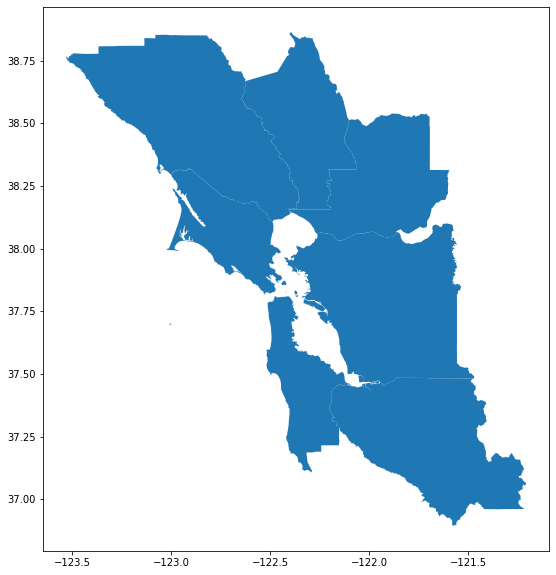

In [84]:
fmr.plot(figsize=(10,10));

In [85]:
parcels_centroid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
fmr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [88]:
a = time.time()
fmr_parcels_centroid = gpd.sjoin(parcels_centroid,
                                 fmr,
                                 how='left',
                                 op='intersects')
b = time.time()
print('took {}'.format(print_runtime(b-a)))

took 3.4828 minutes


In [89]:
fmr_parcels_centroid.head(5)

,geometry,rhna_4,fmr_3bdr_left,acres,geom_id,vmt,sea_level,plu_gp,tra,fmr_4bdr_left,...,fmr_2bdr_right,fmr_3bdr_right,fmr_4bdr_right,fmr_area,fmr_code,fmr_4plbdr_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area
0,POINT (-122.33544 37.98419),None,None,0.014507214240153,5444677669878114970,None,None,None,None,None,...,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083
1,POINT (-121.99306 37.22761),None,None,0.16061245152327,N4044063777024811420,None,None,None,None,None,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
2,POINT (-121.81830 37.25810),None,None,0.210733707033247,2265894416468866674,None,None,None,None,None,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
3,POINT (-122.03819 37.31797),None,None,0.176850694083858,3935937022401185163,None,None,None,None,None,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
4,POINT (-122.36061 37.58385),None,None,0.0917729735371208,N3788479476165547265,None,None,None,None,None,...,2809.0,3663.0,3912.0,"San Francisco, CA HUD Metro FMR Area",METRO41860MM7360,3912.0,4.275324e+09,955407.207799,7.646650,0.272706


In [90]:
fmr_parcels_centroid[fmr_parcels_centroid['fmr_code'].isnull()].shape

(2574, 45)

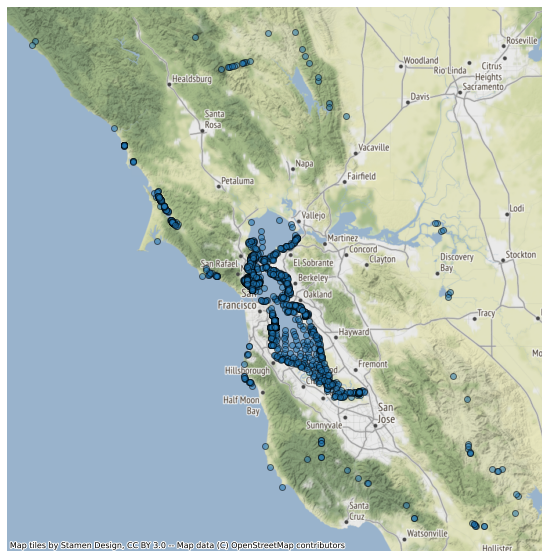

In [93]:
fmr_null_parcels = (fmr_parcels_centroid[fmr_parcels_centroid['index_right'].isnull()]
                    .to_crs('epsg:3857')
                   )
ax = fmr_null_parcels.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ax.set_axis_off()
ctx.add_basemap(ax);

### Upsert to socrata

Resulting fields added:

- **fmr_0bdr**
- **fmr_1bdr**
- **fmr_2bdr**
- **fmr_3bdr**
- **fmr_4bdr**
- **fmr_4plbdr**

In [94]:
sub_columns = ['parcel_id',
               'fmr_0bdr',
               'fmr_1bdr',
               'fmr_2bdr',
               'fmr_3bdr',
               'fmr_4bdr',
               'fmr_4plbdr']

# upsert_df_socrata(fmr_parcels_centroid[sub_columns],
#                   housing_site_db_id,
#                   chunksize=50000)

**[Back to Top](#top)**

**[Back to Section Top](#opportunity)**

**[Skip to next section](#environment)**

## Step 5: Process accessibility datasets <a name="accessibility"></a>

#### [A. MTC/ABAG Transit Rich Areas 2020 (TRAs)](#tra)

- Transit rich areas will be assigned to parcels using a point (representative centroid) in polygon (Transit Rich Area) method. This is a simple boolean flagging (0: Outside TRA, 1: Inside TRA) 

A Transit-Rich Area is defined as areas 1/2 mile of:
- An existing, under construction, or fully funded rail station or ferry terminal
- A rail station or ferry terminal included in the PBA 2050 Final Blueprint
- A bus stop with headways of 15 minutes or less during the AM (6:00 - 10:00 AM) and PM (3:00 - 7:00 PM) peak periods in January 2020

Resulting field added:  **tra**

#### [B. Travel Model I Vehicle Miles Traveled (VMT)](#vmt)

**TODO**

Resulting field added:  **vmt**

**[Back to Top](#top)**

**[Back to Section Top](#accessibility)**

### 5A. Process Transit Rich Areas <a name="tra"></a>

Result of this step: Add **tra** field to Socrata dataset

**[Skip to next step](#vmt)**

In [98]:
# tra_2020 = pull_geodata_from_argis('81a628f55b3d458095c9770331aca5a4',client=gis) 
# tra_2020

fiona.listlayers(gdb_path)

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'art_slr_inundation_poly_77',
 'art_slr_lowlying_poly_77',
 'california_protected_areas_datbase_bay_area']

In [99]:
# Read transit rich areas 2020 data from project fgdb
tra_2020 = gpd.read_file(gdb_path,
                         driver='FileGDB',
                         layer='transit_rich_areas_2020')

In [100]:
tra_2020.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [101]:
#rename dissolve column to tra
tra_2020.rename(columns={'diss':'tra'}, inplace=True)

In [104]:
tra_2020.crs = 'EPSG:4326'

In [105]:
# Check CRS
print(parcels_centroid.crs)
print(tra_2020.crs)

EPSG:4326
EPSG:4326


In [106]:
# Spatially join parcel centroids and tras
tra_parcel_centroid = gpd.sjoin(parcels_centroid,
                                tra_2020,
                                how='left',
                                op='intersects')

tra_parcel_centroid.head()

,geometry,rhna_4,fmr_3bdr,acres,geom_id,vmt,sea_level,plu_gp,tra_left,fmr_4bdr,...,rhna_5,bldg_permt,blkg_geoid,public_own,cpad,index_right,tra_right,f_name,Shape_Length,Shape_Area
0,POINT (-122.33544 37.98419),None,None,0.014507214240153,5444677669878114970,None,None,None,None,None,...,None,None,060133650031,None,None,0.0,1.0,Transit Rich Areas,12.296486,0.122582
1,POINT (-121.99306 37.22761),None,None,0.16061245152327,N4044063777024811420,None,None,None,None,None,...,None,None,060855070012,None,None,NaN,NaN,NaN,NaN,NaN
2,POINT (-121.81830 37.25810),None,None,0.210733707033247,2265894416468866674,None,None,None,None,None,...,None,None,060855120221,None,None,0.0,1.0,Transit Rich Areas,12.296486,0.122582
3,POINT (-122.03819 37.31797),None,None,0.176850694083858,3935937022401185163,None,None,None,None,None,...,None,None,060855077013,None,None,0.0,1.0,Transit Rich Areas,12.296486,0.122582
4,POINT (-122.36061 37.58385),None,None,0.0917729735371208,N3788479476165547265,None,None,None,None,None,...,None,None,060816053001,None,None,0.0,1.0,Transit Rich Areas,12.296486,0.122582


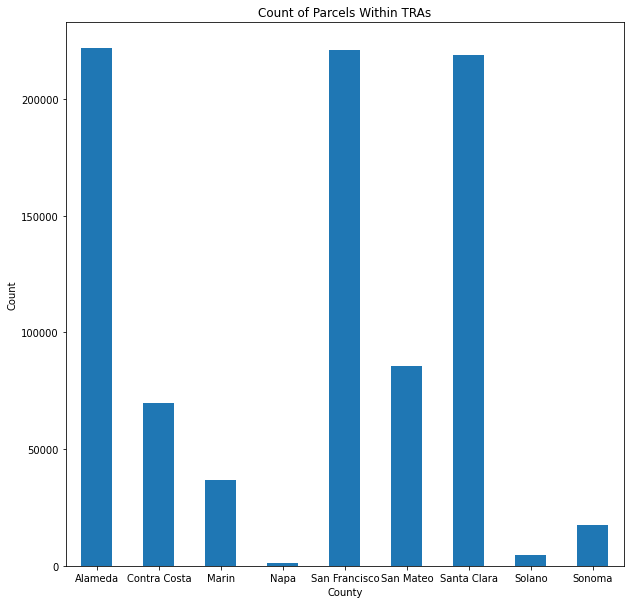

In [108]:
# Graph major stop parcels by county
parcels_tra_ct = (tra_parcel_centroid[tra_parcel_centroid['tra_right'].notnull()]
                  .groupby(['county'])
                  .agg('size')
                 )

#plot
parcels_tra_ct.plot(kind='bar',figsize=(10,10))

#title and labels
plt.title('Count of Parcels Within TRAs')
plt.xlabel('County')
plt.ylabel('Count')

plt.xticks( 
    [0,1,2,3,4,5,6,7,8], # positions
    ['Alameda',
     'Contra Costa',
     'Marin',
     'Napa',
     'San Francisco',
     'San Mateo',
     'Santa Clara',
     'Solano',
     'Sonoma'], # labels
    rotation = 0 # default is 90
)

# convert to non-scientific notation 
plt.ticklabel_format(axis = 'y', style='plain');

In [111]:
#subset SF to view
parcels_tra_al = tra_parcel_centroid[(tra_parcel_centroid['tra_right'] == 1) & 
                                               (tra_parcel_centroid['county'] == 'CA001')]

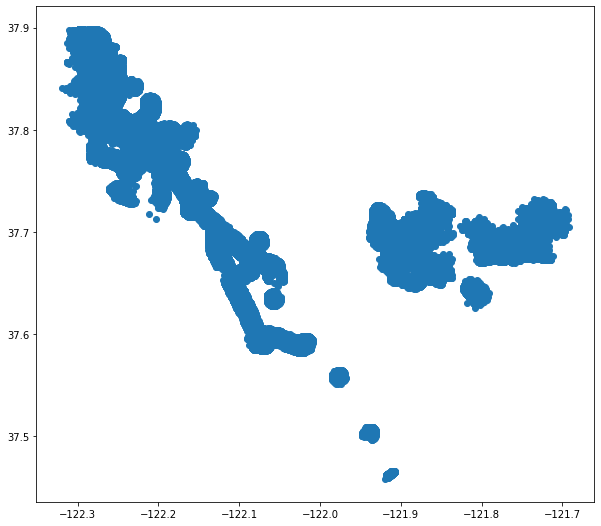

In [112]:
parcels_tra_al.plot(figsize=(10,10));

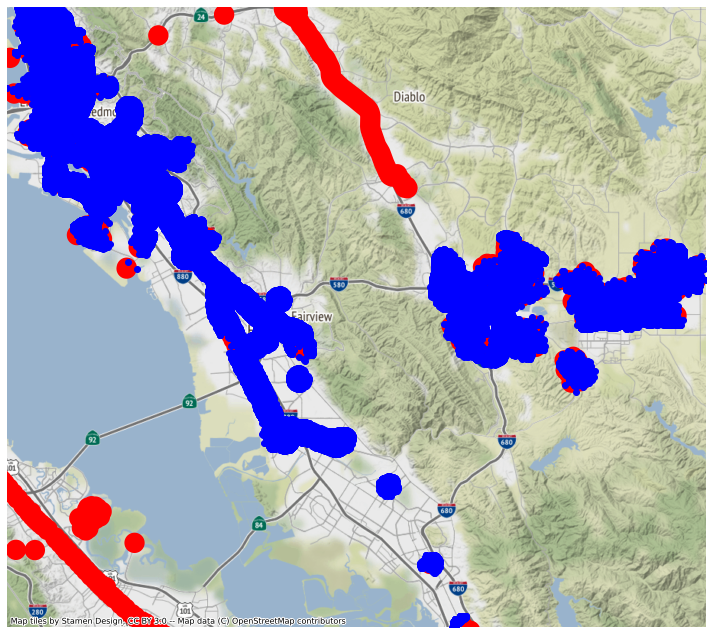

In [113]:
fig, ax = plt.subplots(figsize=(10,10))

tra_2020.to_crs('epsg:3857').plot(color='red',ax=ax)

parcels_tra_al.to_crs('epsg:3857').plot(color='blue',ax=ax)

# Crop map to sf bounds
minx, miny, maxx, maxy = parcels_tra_al.to_crs('epsg:3857').geometry.total_bounds

ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)
ax.set_axis_off()
ctx.add_basemap(ax)

#Display map
plt.tight_layout()
plt.show()

In [114]:
#Fill tpa flag column NaN values
tra_parcel_centroid['tra_right'].fillna(0,inplace=True)

In [115]:
tra_parcel_centroid = tra_parcel_centroid.rename(columns={'tra_right': 'tra'})
tra_parcel_centroid = tra_parcel_centroid[['parcel_id', 'tra']]
tra_parcel_centroid.head()

,parcel_id,tra
0,CC208679,1.0
1,SC247811,0.0
2,SC412297,1.0
3,SC037475,1.0
4,SM079992,1.0


### Upsert to socrata

Resulting field added:  **tra**

In [116]:
# upsert_df_socrata(tra_parcel_centroid,
#                   housing_site_db_id,
#                   chunksize=100000)

**[Back to Top](#top)**

**[Back to Section Top](#accessibility)**

### 5B. Process Travel Model I VMT <a name="vmt"></a>

### TODO

Result of this step: Add **vmt** field to Socrata dataset

**[Back to previous step](#tra)**

**[Skip to next section](#environment)**

In [ ]:
# TODO

### Upsert to socrata

Resulting field added:  **vmt**

In [ ]:
# TODO

# upsert_df_socrata(vmt_df,
#                   housing_site_db_id,
#                   chunksize=100000)

**[Back to Top](#top)**

**[Back to previous section](#accessibility)**

**[Skip to next section](#planning)**

## Step 6: Process environment datasets <a name="environment"></a>

#### [A. California Protected Area Database](#cpad)
- California Protected Areas (CPAD) will be assigned to parcels using a simple point in polygon spatial join method. Parcel centroids that intersect CPAD areas will be flagged (0: Outside CPAD Area, 1: Inside CPAD Area)

Resulting field added:  **cpad**

#### [B. Fire Severity Risk: State and Local Responsibility Areas](#fsr)

Fire Severity Risk in State and Local Responsibility Areas for the San Francisco Bay Region. Data downloaded from the California Department of Forestry and Fire Protection.

This data set represents Moderate, High, and Very High Fire Hazard Severity Zones in State Responsibility Areas (SRA) and Very High Fire Hazard Severity Zones in Local Responsibility Areas (LRA) for the San Francisco Bay Region and surrounding counties. The data was assembled by the Metropolitan Transportation Commission from multiple shapefiles provided by the California Department of Forestry and Fire Protection (CAL FIRE). The SRA data was extracted from a statewide shapefile and the LRA data is a combination of county shapefiles.

- Columns from this dataset that will be associated with parcels include:
    - Fire Risk Severity 
    - Fire Responsibility Areas

- Fire risk severity will be assigned to parcels using a point in polygon spatial join method. 
- Fire severity classifications will be added to any parcel centroid that intersections the fire severity polygon.

Resulting fields added:  **tra**

#### [C. BCDC Sea Level Rise Inundation](#slr)

Resulting fields added: **sea_level**

**[Back to Top](#top)**

**[Back to Section Top](#environment)**

### 6A. Process California Protected Area Database data <a name="cpad"></a>

Result of this step: Add **cpad** field to Socrata dataset

**[Skip to next step](#fsr)**

In [153]:
fiona.listlayers(gdb_path)

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'california_protected_areas_datbase_bay_area',
 'art_slr_inundation_poly_77',
 'art_slr_lowlying_poly_77']

In [121]:
#Read fire severity risk data from project fgdb
cpad = gpd.read_file(gdb_path,
                     driver='FileGDB',
                     layer='california_protected_areas_datbase_bay_area')

cpad.head(5)

,access_typ,park_name,park_url,suid_nma,mng_ag_id,mng_agency,mng_ag_lev,mng_ag_typ,agncy_web,layer,acres,label_name,yr_est,shape_Length,shape_Area,geometry
0,Open Access,Modini Mayacamas Preserves,http://egret.org/visit_modini_mayacamas,383,3005,Audubon Canyon Ranch,Non Profit,Non Profit - Conservation,http://www.egret.org,Non Governmental Organization,1279.161,Modini Mayacamas Preserves,0,0.129172,0.000536,"MULTIPOLYGON (((-122.76950 38.74085, -122.7657..."
1,Open Access,Vintage Meadows Park,,33477,1059,"Cloverdale, City of",City,City Agency,http://www.cloverdale.net/index.aspx?nid=152,City,3.513,Vintage Meadows Park,0,0.004803,0.000001,"MULTIPOLYGON (((-123.02368 38.79883, -123.0244..."
2,Open Access,Water Dog Lake Canyon,http://www.belmont.gov/Home/Components/Facilit...,534,1025,"Belmont, City of",City,City Agency,http://www.belmont.gov/city-hall/park-and-recr...,City,276.470,Water Dog Lake Canyon,1975,0.112598,0.000114,"MULTIPOLYGON (((-122.30523 37.51002, -122.3053..."
3,Open Access,McKegney Green,,31739,1348,"Tiburon, Town of",City,City Agency,http://www.ci.tiburon.ca.us/,City,11.486,McKegney Green,0,0.017734,0.000005,"MULTIPOLYGON (((-122.48771 37.89490, -122.4863..."
4,Open Access,Richardson Bay Lineal Park,,31740,1348,"Tiburon, Town of",City,City Agency,http://www.ci.tiburon.ca.us/,City,11.346,Richardson Bay Lineal Park,0,0.053122,0.000005,"MULTIPOLYGON (((-122.46377 37.87877, -122.4635..."


In [122]:
parcels_centroid.head(5)

,geometry,rhna_4,fmr_3bdr,acres,geom_id,vmt,sea_level,plu_gp,tra,fmr_4bdr,...,fmr_1bdr,parcel_id,trct_geoid,plu_zoning,apn,rhna_5,bldg_permt,blkg_geoid,public_own,cpad
0,POINT (-122.33544 37.98419),None,None,0.014507214240153,5444677669878114970,None,None,None,None,None,...,None,CC208679,06013365003,None,405520022,None,None,060133650031,None,None
1,POINT (-121.99306 37.22761),None,None,0.16061245152327,N4044063777024811420,None,None,None,None,None,...,None,SC247811,06085507001,None,51040146,None,None,060855070012,None,None
2,POINT (-121.81830 37.25810),None,None,0.210733707033247,2265894416468866674,None,None,None,None,None,...,None,SC412297,06085512022,None,69011039,None,None,060855120221,None,None
3,POINT (-122.03819 37.31797),None,None,0.176850694083858,3935937022401185163,None,None,None,None,None,...,None,SC037475,06085507701,None,35914044,None,None,060855077013,None,None
4,POINT (-122.36061 37.58385),None,None,0.0917729735371208,N3788479476165547265,None,None,None,None,None,...,None,SM079992,06081605300,None,026221230,None,None,060816053001,None,None


In [123]:
cpad.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [124]:
# Spatially join parcel centroids with CPAD
cpad_parcels_centroid = gpd.sjoin(parcels_centroid,
                                  cpad,
                                  how='left',
                                  op='intersects')

In [125]:
cpad_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142681 entries, 0 to 2142676
Data columns (total 48 columns):
 #   Column        Dtype   
---  ------        -----   
 0   geometry      geometry
 1   rhna_4        object  
 2   fmr_3bdr      object  
 3   acres_left    object  
 4   geom_id       object  
 5   vmt           object  
 6   sea_level     object  
 7   plu_gp        object  
 8   tra           object  
 9   fmr_4bdr      object  
 10  urban_serv    object  
 11  rsrc_level    object  
 12  fmr_0bdr      object  
 13  centroid_y    float64 
 14  fire_risk     object  
 15  county        object  
 16  exist_lu      object  
 17  fmr_4plbdr    object  
 18  jurisdict     object  
 19  centroid_x    float64 
 20  fmr_2bdr      object  
 21  fire_autho    object  
 22  fmr_1bdr      object  
 23  parcel_id     object  
 24  trct_geoid    object  
 25  plu_zoning    object  
 26  apn           object  
 27  rhna_5        object  
 28  bldg_permt    object  
 29  blkg_g

In [126]:
cpad_parcels_centroid.head()

,geometry,rhna_4,fmr_3bdr,acres_left,geom_id,vmt,sea_level,plu_gp,tra,fmr_4bdr,...,mng_agency,mng_ag_lev,mng_ag_typ,agncy_web,layer,acres_right,label_name,yr_est,shape_Length,shape_Area
0,POINT (-122.33544 37.98419),None,None,0.014507214240153,5444677669878114970,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-121.99306 37.22761),None,None,0.16061245152327,N4044063777024811420,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (-121.81830 37.25810),None,None,0.210733707033247,2265894416468866674,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-122.03819 37.31797),None,None,0.176850694083858,3935937022401185163,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-122.36061 37.58385),None,None,0.0917729735371208,N3788479476165547265,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
cpad_parcels_centroid[cpad_parcels_centroid['index_right'].notnull()].shape  # (17344, 27)

(17344, 48)

In [128]:
# Add cpad flag column
cpad_parcels_centroid['cpad'] = np.where(cpad_parcels_centroid['index_right'].notnull(),
                                         1,
                                         0)

In [129]:
# Review number of parcels flagged as park by county
(cpad_parcels_centroid[cpad_parcels_centroid['cpad'] ==1]
 .groupby(['cpad','county'])[['cpad','county']]
 .sum()
)

cpad
cpad county      
1    CA001   2742
     CA013   2365
     CA041   2264
     CA055    920
     CA075    967
     CA081   2259
     CA085   2880
     CA095   1113
     CA097   1834

In [130]:
cpad_parcels_centroid[['parcel_id', 'cpad']].head()

,parcel_id,cpad
0,CC208679,0
1,SC247811,0
2,SC412297,0
3,SC037475,0
4,SM079992,0


### Upsert to socrata

Resulting field added:  **cpad**

In [131]:
# upsert_df_socrata(cpad_parcels_centroid[['parcel_id', 'cpad']],
#                   housing_site_db_id,
#                   chunksize=100000)

**[Back to Top](#top)**

**[Back to Section Top](#environment)**

### 6B. Process Fire Severity Risk data <a name="fsr"></a>

Result of this step: Add **fire_risk** and **fire_autho** fields to Socrata dataset

**[Back to previous step](#cpad)**

**[Skip to next step](#slr)**

In [132]:
fiona.listlayers(gdb_path)

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'art_slr_inundation_poly_77',
 'art_slr_lowlying_poly_77',
 'california_protected_areas_datbase_bay_area']

In [133]:
# Read fire severity risk data from project fgdb
fsr = gpd.read_file(gdb_path,
                    driver='FileGDB',
                    layer='cdf_fire_responsibility_areas_and_risk')

fsr.head(5)

,fipco,incorp,fra,haz_code,haz_class,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,CA001,,LRA,3,Very High,0.000106,0.086169,0.086169,0.000106,"MULTIPOLYGON (((-121.88522 37.59440, -121.8854..."
1,CA001,,LRA,3,Very High,0.000036,0.038931,0.038931,0.000036,"MULTIPOLYGON (((-121.90256 37.63428, -121.9024..."
2,CA001,,LRA,3,Very High,0.000362,0.255788,0.255788,0.000362,"MULTIPOLYGON (((-122.12722 37.71571, -122.1271..."
3,CA001,,LRA,3,Very High,0.000003,0.007693,0.007693,0.000003,"MULTIPOLYGON (((-122.12484 37.72801, -122.1249..."
4,CA001,Y,LRA,3,Very High,0.000067,0.050632,0.050632,0.000067,"MULTIPOLYGON (((-121.88361 37.62573, -121.8834..."


In [134]:
# Rename columns to match final data schema
fsr = (fsr
       .rename(columns={'haz_class':'fire_risk',
                        'fra':'fire_autho'})
      )

In [135]:
fsr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   fipco          5772 non-null   object  
 1   incorp         5772 non-null   object  
 2   fire_autho     5772 non-null   object  
 3   haz_code       5772 non-null   int64   
 4   fire_risk      5772 non-null   object  
 5   Shape__Area    5772 non-null   float64 
 6   Shape__Length  5772 non-null   float64 
 7   Shape_Length   5772 non-null   float64 
 8   Shape_Area     5772 non-null   float64 
 9   geometry       5772 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(4)
memory usage: 451.1+ KB


In [136]:
fsr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [146]:
#Spatial join parcel centroids to fire risk areas
fsr_parcels_centroid = gpd.sjoin(parcels_centroid,
                                 fsr,
                                 how='inner',
                                 op='intersects')

print(fsr_parcels_centroid.shape)  # (179714, 21)
fsr_parcels_centroid.head()

(179714, 42)


,geometry,rhna_4,fmr_3bdr,acres,geom_id,vmt,sea_level,plu_gp,tra,fmr_4bdr,...,index_right,fipco,incorp,fire_autho_right,haz_code,fire_risk_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area
1,POINT (-121.99306 37.22761),None,None,0.16061245152327,N4044063777024811420,None,None,None,None,None,...,78,CA085,Y,LRA,3,Very High,0.002893,0.880164,0.880164,0.002893
164,POINT (-121.98929 37.22647),None,None,0.183074605858483,N5478356684453901404,None,None,None,None,None,...,78,CA085,Y,LRA,3,Very High,0.002893,0.880164,0.880164,0.002893
1030,POINT (-121.94942 37.23095),None,None,1.53870799343753,N299450109609942562,None,None,None,None,None,...,78,CA085,Y,LRA,3,Very High,0.002893,0.880164,0.880164,0.002893
1379,POINT (-122.02266 37.24680),None,None,0.142790113785233,3338103928294412269,None,None,None,None,None,...,78,CA085,Y,LRA,3,Very High,0.002893,0.880164,0.880164,0.002893
3548,POINT (-121.98812 37.22557),None,None,0.352491697890627,N8244539272441238523,None,None,None,None,None,...,78,CA085,Y,LRA,3,Very High,0.002893,0.880164,0.880164,0.002893


In [147]:
fsr_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 179714 entries, 1 to 2139817
Data columns (total 42 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   geometry          179714 non-null  geometry
 1   rhna_4            0 non-null       object  
 2   fmr_3bdr          0 non-null       object  
 3   acres             179714 non-null  object  
 4   geom_id           179714 non-null  object  
 5   vmt               0 non-null       object  
 6   sea_level         0 non-null       object  
 7   plu_gp            0 non-null       object  
 8   tra               0 non-null       object  
 9   fmr_4bdr          0 non-null       object  
 10  urban_serv        0 non-null       object  
 11  rsrc_level        0 non-null       object  
 12  fmr_0bdr          0 non-null       object  
 13  centroid_y        179714 non-null  float64 
 14  fire_risk_left    0 non-null       object  
 15  county            179714 non-null  object 

In [148]:
rename_d = {'fire_risk_right': 'fire_risk',
            'fire_autho_right': 'fire_autho'}

fsr_parcels_centroid = fsr_parcels_centroid.rename(columns=rename_d)

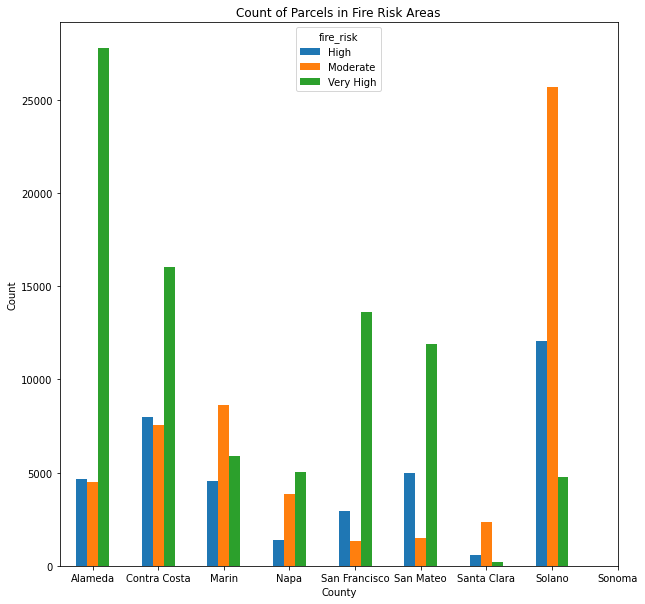

In [149]:
fsr_risk_by_county = (fsr_parcels_centroid
                      .groupby(['county','fire_risk'])[['county','fire_risk']]
                      .agg('size')
                     )

#plot
fsr_risk_by_county.unstack().plot(kind='bar',figsize=(10,10))

#title and labels
plt.title('Count of Parcels in Fire Risk Areas')
plt.xlabel('County')
plt.ylabel('Count')

plt.xticks( 
    [0,1,2,3,4,5,6,7,8], # positions
    ['Alameda',
     'Contra Costa',
     'Marin',
     'Napa',
     'San Francisco',
     'San Mateo',
     'Santa Clara',
     'Solano',
     'Sonoma'], # labels
    rotation = 0 # default is 90
)

# convert to non-scientific notation 
plt.ticklabel_format(axis = 'y', style='plain');

In [143]:
fsr_parcels_centroid = fsr_parcels_centroid[['parcel_id','fire_autho','fire_risk']]
fsr_parcels_centroid.head()

,parcel_id,fire_autho,fire_risk
1,SC247811,LRA,Very High
164,SC116542,LRA,Very High
1030,SC300710,LRA,Very High
1379,SC032561,LRA,Very High
3548,SC312835,LRA,Very High


### Upsert to socrata

Resulting fields added:
- **fire_risk**
- **fire_autho**

In [144]:
# upsert_df_socrata(fsr_parcels_centroid,
#                   housing_site_db_id)

**[Back to Top](#top)**

**[Back to Section Top](#environment)**

### 6C. Process BCDC Sea Level Rise Dataset <a name="slr"></a>

Result of this step: Add **sea_level** field to Socrata dataset

**[Back to previous step](#fsr)**

**[Skip to next section](#planning)**

In [154]:
fiona.listlayers(gdb_path)

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'california_protected_areas_datbase_bay_area',
 'art_slr_inundation_poly_77',
 'art_slr_lowlying_poly_77']

In [152]:
# BCDC Sea Level Rise Data
bcdc = gpd.read_file(gdb_path,
                     driver='FileGDB',
                     layer='art_slr_inundation_poly_77')

### Upsert to socrata

Resulting field added:  **sea_level**

In [ ]:
# # TODO
# upsert_df_socrata(bcdc[['parcel_id','sea_level']],
#                   housing_site_db_id)

**[Back to Top](#top)**

**[Back to previous section](#environment)**

## Step 7: Process planning datasets <a name="planning"></a>

#### [A. Priority Development Areas](#pda)

- Flag column (0: Outside PDA; 1: Inside PDA) 

#### [B. Prior RHNA sites data](#rhna)

Following the adoption of the Regional Housing Need Assessment (RHNA), each jurisdiction is required to update its housing element to identify sites adequate to accommodate the number of units allocated to them. The parcel list was compiled from the housing opportunity sites inventories prepared by each of the Bay Area's 101 cities and nine counties as part of the 2007-2014 and 2015-2023 RHNA housing element cycles.

- RHNA 4 and RHNA 5 columns will be flagged (0: Not a previous RHNA site, 1: Was a previous RHNA site), depending on RHNA cycle. 

#### [C. Zoning](#zoning)

Zoning data was compiled form zoning ordinances for every city and county in the Bay Area. This data includes the zoning code, description, overlay, and maxiumum allowable residential density as well as other information. 

- Columns from this dataset that will be associated with parcels include:
    - Zoning Code
    - Zoning Code Description
    - Zoning Overlay Description
    - Maximum Dwelling Units / Acre (Allowable Density) 

#### [D. General Plan](#generalplan)

General plan data was compiled from some general plans but is incomplete. The data collected includes general plan code, description, and maxiumum allowable residential density. 

- Columns from this dataset that will be associated with parcels include: 
    - General Plan Code
    - General Plan Code Description
    - Maxium Dwelling Units / Acre (Allowable Density) 

#### Regional Property Characteristics 

Regional property chracteristics were collected from each of the 9-County Assessor's offices in the Bay Area. 

- Columns from this dataset that will be associated with parcels include: 
    - Existing Use Code
    - Existing Use Code Description 
    - Public Ownership 
    - Vacant Parcel 
    - Underutilized 

**[Back to Top](#top)**

**[Back to Section Top](#planning)**

### 7A. Process Priority Development Areas <a name="pda"></a>

Result of this step: Add **pda** field to Socrata dataset

**[Skip to next step](#rhna)**

In [139]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk']

In [140]:
pda = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='priority_development_areas_current')

In [141]:
pda.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [142]:
pda.head(5)

,join_key,county,jurisdicti,pda_name,acres,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,230ec884-82c6-4074-a3e2-877bb1cea97b,Alameda,Berkeley,North Berkeley BART,13,0.000005,0.009432,0.009432,0.000005,"MULTIPOLYGON (((-122.28492 37.87463, -122.2847..."
1,0a13cdcd-d2e8-46e1-8652-60d54f28c843,Alameda,Fremont,Irvington Transit Priority Development Area,803,0.000331,0.095005,0.095005,0.000331,"MULTIPOLYGON (((-121.96350 37.53871, -121.9603..."
2,a75db8bd-4a27-4288-b878-24cee994e148,Alameda,Fremont,Centerville Transit Priority Development Area,582,0.000240,0.064045,0.064045,0.000240,"MULTIPOLYGON (((-122.00152 37.56471, -122.0015..."
3,84b5bd67-82eb-4202-9a66-a978d2218197,Alameda,Fremont,Downtown/City CenterTransit Priority Developme...,920,0.000380,0.089982,0.089982,0.000380,"MULTIPOLYGON (((-121.97847 37.54683, -121.9786..."
4,f50e7d2c-0fce-4fb6-83bb-7c037aa9446a,Alameda,Fremont,Warm Springs Innovation District Transit Prior...,913,0.000376,0.091934,0.091934,0.000376,"MULTIPOLYGON (((-121.94186 37.51030, -121.9417..."


In [143]:
#Spatially join parcel centroids w/ pdas
pda_parcel_centroid = gp.sjoin(parcels_centroid,
                              pda,
                              how='left',
                              op='intersects')

In [144]:
pda_parcel_centroid.head(5)

,parcel_id,geom_id,county_left,city,apn,acres_left,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,index_right,join_key,county_right,jurisdicti,pda_name,acres_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area
0,AL99A256000110,N5817775096018233128,1.0,Unincorporated Alameda,99A256000110,106.927944937336,06001451101,060014511013,-121.596790,37.581694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL525128205800,7316709377530651714,1.0,Fremont,525128205800,0.370856727459726,06001443002,060014430023,-121.957118,37.521598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL99A256000109,N527005802064910811,1.0,Unincorporated Alameda,99A256000109,101.938704741621,06001451101,060014511013,-121.603007,37.581767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL986001300100,3727940690343027220,1.0,Dublin,986001300100,1.27190710767633,06001450102,060014501023,-121.881581,37.709281,...,92.0,bec430c5-1512-4f41-92d8-0356caf9c22a,Alameda,Dublin,Town Center,676.0,0.00028,0.091905,0.091905,0.00028
4,AL99A293200300,2796948223684118431,1.0,Unincorporated Alameda,99A293200300,2.10466188922604,06001451501,060014515012,-121.729299,37.669970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
pda_parcel_centroid[pda_parcel_centroid['index_right'].notnull()].shape

(401581, 21)

In [146]:
pda_parcel_centroid['pda'] = np.where(pda_parcel_centroid['index_right'].notnull(),1,0)

In [147]:
pda_parcel_centroid[pda_parcel_centroid['pda'] == 1].head(5)

,parcel_id,geom_id,county_left,city,apn,acres_left,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,join_key,county_right,jurisdicti,pda_name,acres_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area,pda
3,AL986001300100,3727940690343027220,1.0,Dublin,986001300100,1.27190710767633,06001450102,060014501023,-121.881581,37.709281,...,bec430c5-1512-4f41-92d8-0356caf9c22a,Alameda,Dublin,Town Center,676.0,0.000280,0.091905,0.091905,0.000280,1
7,AL543042806300,N4262495264119460416,1.0,Fremont,543042806300,1.52529970991809,06001441401,060014414014,-122.033590,37.570074,...,695db3f4-bd3b-4716-9a9b-8c1e9d6e2e2a,Alameda,Fremont,North Fremont Boulevard Connected Community Pr...,732.0,0.000302,0.118105,0.118105,0.000302,1
18,SF3514197,507393735700634042,75.0,San Francisco,3514197,0.989925861588401,06075020100,060750201001,-122.418802,37.771564,...,d397f42d-18fb-4e1b-9f97-3fb6597e9208,San Francisco,San Francisco,Market Octavia,536.0,0.000222,0.100755,0.100755,0.000222,1
20,SF3514049,507393735700634042,75.0,San Francisco,3514049,0.989925861588401,06075020100,060750201001,-122.418802,37.771564,...,d397f42d-18fb-4e1b-9f97-3fb6597e9208,San Francisco,San Francisco,Market Octavia,536.0,0.000222,0.100755,0.100755,0.000222,1
21,SF3514102,507393735700634042,75.0,San Francisco,3514102,0.989925861588401,06075020100,060750201001,-122.418802,37.771564,...,d397f42d-18fb-4e1b-9f97-3fb6597e9208,San Francisco,San Francisco,Market Octavia,536.0,0.000222,0.100755,0.100755,0.000222,1


### Upsert to socrata

Resulting field added:  **pda**

In [156]:
# upsert_df_socrata(pda_parcel_centroid[['parcel_id','pda']],
#                   housing_site_db_id,
#                   chunksize=100000)

**[Back to Top](#top)**

**[Back to Section Top](#planning)**

### 7B. Process prior RHNA Sites <a name="rhna"></a>

Result of this step: Add **rhna_4** and **rhna_5** fields to Socrata dataset

**[Back to previous step](#pda)**

**[Skip to next step](#zoning)**

In [157]:
fiona.listlayers(gdb_path)

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'california_protected_areas_datbase_bay_area',
 'art_slr_lowlying_poly_77',
 'art_slr_inundation_poly_77']

In [158]:
# Read RHNA dataset from FileGDB
rhna_sites = gpd.read_file(gdb_path,
                           driver='FileGDB',
                           layer='regional_housing_need_assessment_sites')

In [159]:
rhna_sites.head()

,rhnacyc,rhnayrs,county,jurisdict,apn,locapn,genplan,zoning,gacres,locacres,...,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,shape_Length,shape_Area,geometry
0,RHNA4,2007-2014,6001,Berkeley,055-1825-020-00,055 182502000,AC,C-SA,0.234,0.23,...,None,None,Underutilized,Y,None,Berkeley Honda Car Lot,None,0.001269,9.683965e-08,"MULTIPOLYGON (((-122.26618 37.86184, -122.2664..."
1,RHNA4,2007-2014,6001,Berkeley,057-2059-012-00,057 205901200,DT,C-1,0.099,0.11,...,None,None,Underutilized,Y,None,Flamingo's Cleaners,None,0.001028,4.085816e-08,"MULTIPOLYGON (((-122.27251 37.87207, -122.2726..."
2,RHNA4,2007-2014,6001,Berkeley,055-1829-011-00,055 182901100,MDR,R-2A,0.154,0.15,...,None,None,Vacant,None,None,VACANT,None,0.001089,6.365583e-08,"MULTIPOLYGON (((-122.26420 37.86264, -122.2643..."
3,RHNA4,2007-2014,6001,Berkeley,057-2046-001-00,057 204600100,DT,C-1,0.398,0.40,...,None,None,Underutilized,Y,None,"Missing Link Bicycle Coop, Berkeley Vacuum Center",None,0.001633,1.648733e-07,"MULTIPOLYGON (((-122.26784 37.87269, -122.2680..."
4,RHNA4,2007-2014,6001,Berkeley,057-2053-008-01,057 205300801,DT,C-1,0.266,0.28,...,None,None,Underutilized,Y,None,Lhasa Hair Salon,None,0.001333,1.102806e-07,"MULTIPOLYGON (((-122.26964 37.87213, -122.2700..."


In [160]:
rhna_sites.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42133 entries, 0 to 42132
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   rhnacyc       42133 non-null  object  
 1   rhnayrs       42133 non-null  object  
 2   county        42133 non-null  object  
 3   jurisdict     42133 non-null  object  
 4   apn           42105 non-null  object  
 5   locapn        42128 non-null  object  
 6   genplan       37177 non-null  object  
 7   zoning        33509 non-null  object  
 8   gacres        42133 non-null  float64 
 9   locacres      42133 non-null  float64 
 10  currunits     42133 non-null  int64   
 11  allowden      23912 non-null  object  
 12  allowlow      42133 non-null  int64   
 13  allowhigh     42133 non-null  int64   
 14  relcapcty     31466 non-null  object  
 15  desafford     6044 non-null   object  
 16  aff_vl        1163 non-null   object  
 17  aff_l         1591 non-null   object  
 18

In [161]:
rhna_sites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [162]:
#Spatially join parcel centroids with rhna dataset
rhna_parcels_centroid = gpd.sjoin(parcels_centroid,
                                  rhna_sites[['rhnacyc', 'geometry']],
                                  how='left',
                                  op='intersects')

In [163]:
rhna_parcels_centroid.head(5)

,geometry,rhna_4,fmr_3bdr,acres,geom_id,vmt,sea_level,plu_gp,tra,fmr_4bdr,...,trct_geoid,plu_zoning,apn,rhna_5,bldg_permt,blkg_geoid,public_own,cpad,index_right,rhnacyc
0,POINT (-122.33544 37.98419),None,None,0.014507214240153,5444677669878114970,None,None,None,None,None,...,06013365003,None,405520022,None,None,060133650031,None,None,NaN,NaN
1,POINT (-121.99306 37.22761),None,None,0.16061245152327,N4044063777024811420,None,None,None,None,None,...,06085507001,None,51040146,None,None,060855070012,None,None,NaN,NaN
2,POINT (-121.81830 37.25810),None,None,0.210733707033247,2265894416468866674,None,None,None,None,None,...,06085512022,None,69011039,None,None,060855120221,None,None,NaN,NaN
3,POINT (-122.03819 37.31797),None,None,0.176850694083858,3935937022401185163,None,None,None,None,None,...,06085507701,None,35914044,None,None,060855077013,None,None,NaN,NaN
4,POINT (-122.36061 37.58385),None,None,0.0917729735371208,N3788479476165547265,None,None,None,None,None,...,06081605300,None,026221230,None,None,060816053001,None,None,NaN,NaN


In [164]:
rhna_parcels_centroid.groupby(['rhnacyc']).agg('size')

rhnacyc
RHNA4    49902
RHNA5    42843
dtype: int64

In [165]:
rhna_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2179929 entries, 0 to 2142676
Data columns (total 34 columns):
 #   Column       Dtype   
---  ------       -----   
 0   geometry     geometry
 1   rhna_4       object  
 2   fmr_3bdr     object  
 3   acres        object  
 4   geom_id      object  
 5   vmt          object  
 6   sea_level    object  
 7   plu_gp       object  
 8   tra          object  
 9   fmr_4bdr     object  
 10  urban_serv   object  
 11  rsrc_level   object  
 12  fmr_0bdr     object  
 13  centroid_y   float64 
 14  fire_risk    object  
 15  county       object  
 16  exist_lu     object  
 17  fmr_4plbdr   object  
 18  jurisdict    object  
 19  centroid_x   float64 
 20  fmr_2bdr     object  
 21  fire_autho   object  
 22  fmr_1bdr     object  
 23  parcel_id    object  
 24  trct_geoid   object  
 25  plu_zoning   object  
 26  apn          object  
 27  rhna_5       object  
 28  bldg_permt   object  
 29  blkg_geoid   object  
 30  public_own

In [166]:
# create new flag columns
rhna_parcels_centroid['rhna_4'] = np.where(rhna_parcels_centroid['rhnacyc'] == 'RHNA4',
                                           1,
                                           0)

rhna_parcels_centroid['rhna_5'] = np.where(rhna_parcels_centroid['rhnacyc'] == 'RHNA5',
                                           1,
                                           0)

In [167]:
print(len(rhna_parcels_centroid[rhna_parcels_centroid['rhnacyc'].notnull()]))  # 92745
rhna_parcels_centroid[rhna_parcels_centroid['rhnacyc'].notnull()].head()

92745


,geometry,rhna_4,fmr_3bdr,acres,geom_id,vmt,sea_level,plu_gp,tra,fmr_4bdr,...,trct_geoid,plu_zoning,apn,rhna_5,bldg_permt,blkg_geoid,public_own,cpad,index_right,rhnacyc
15,POINT (-121.84304 37.71301),1,None,0.113857733378137,N1868647344958538290,None,None,None,None,None,...,06001450751,None,985011304300,0,None,060014507511,None,None,748.0,RHNA4
15,POINT (-121.84304 37.71301),1,None,0.113857733378137,N1868647344958538290,None,None,None,None,None,...,06001450751,None,985011304300,0,None,060014507511,None,None,823.0,RHNA4
78,POINT (-121.89921 37.80236),1,None,0.37167810916925,2712801156942496323,None,None,None,None,None,...,06013355113,None,220080037,0,None,060133551132,None,None,10004.0,RHNA4
115,POINT (-122.38085 37.73455),1,None,3.45041617573828,N5693296607506566273,None,None,None,None,None,...,06075023103,None,4700071,0,None,060750231031,None,None,10500.0,RHNA4
115,POINT (-122.38085 37.73455),0,None,3.45041617573828,N5693296607506566273,None,None,None,None,None,...,06075023103,None,4700071,1,None,060750231031,None,None,28865.0,RHNA5


In [168]:
parcels_centroid.shape  # (2142677, 32)

(2142677, 32)

In [169]:
rhna_parcels_centroid.shape  # (2179929, 34)

(2179929, 34)

In [170]:
rhna_parcels_centroid['parcel_id'].value_counts().head()

SM222824    30
SM222151    30
SM223511    30
SM219114    30
SM219815    30
Name: parcel_id, dtype: int64

In [172]:
rhna_parcels_centroid[rhna_parcels_centroid.duplicated(subset=['parcel_id'])].shape
# (37252, 34)

(37252, 34)

In [173]:
# De-duplicate
rhna_parcels_centroid_dedup = rhna_parcels_centroid.drop_duplicates(subset=['parcel_id'])

rhna_parcels_centroid_dedup.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142677 entries, 0 to 2142676
Data columns (total 34 columns):
 #   Column       Dtype   
---  ------       -----   
 0   geometry     geometry
 1   rhna_4       int64   
 2   fmr_3bdr     object  
 3   acres        object  
 4   geom_id      object  
 5   vmt          object  
 6   sea_level    object  
 7   plu_gp       object  
 8   tra          object  
 9   fmr_4bdr     object  
 10  urban_serv   object  
 11  rsrc_level   object  
 12  fmr_0bdr     object  
 13  centroid_y   float64 
 14  fire_risk    object  
 15  county       object  
 16  exist_lu     object  
 17  fmr_4plbdr   object  
 18  jurisdict    object  
 19  centroid_x   float64 
 20  fmr_2bdr     object  
 21  fire_autho   object  
 22  fmr_1bdr     object  
 23  parcel_id    object  
 24  trct_geoid   object  
 25  plu_zoning   object  
 26  apn          object  
 27  rhna_5       int64   
 28  bldg_permt   object  
 29  blkg_geoid   object  
 30  public_own

In [174]:
rhna_parcels_centroid_dedup.head()

,geometry,rhna_4,fmr_3bdr,acres,geom_id,vmt,sea_level,plu_gp,tra,fmr_4bdr,...,trct_geoid,plu_zoning,apn,rhna_5,bldg_permt,blkg_geoid,public_own,cpad,index_right,rhnacyc
0,POINT (-122.33544 37.98419),0,None,0.014507214240153,5444677669878114970,None,None,None,None,None,...,06013365003,None,405520022,0,None,060133650031,None,None,NaN,NaN
1,POINT (-121.99306 37.22761),0,None,0.16061245152327,N4044063777024811420,None,None,None,None,None,...,06085507001,None,51040146,0,None,060855070012,None,None,NaN,NaN
2,POINT (-121.81830 37.25810),0,None,0.210733707033247,2265894416468866674,None,None,None,None,None,...,06085512022,None,69011039,0,None,060855120221,None,None,NaN,NaN
3,POINT (-122.03819 37.31797),0,None,0.176850694083858,3935937022401185163,None,None,None,None,None,...,06085507701,None,35914044,0,None,060855077013,None,None,NaN,NaN
4,POINT (-122.36061 37.58385),0,None,0.0917729735371208,N3788479476165547265,None,None,None,None,None,...,06081605300,None,026221230,0,None,060816053001,None,None,NaN,NaN


### Upsert to socrata

Resulting fields added:
- **rhna_4**
- **rhna_5**

In [175]:
# upsert_df_socrata(rhna_parcels_centroid_dedup[['parcel_id', 'rhna_4', 'rhna_5']],
#                   housing_site_db_id,
#                   chunksize=100000)

**[Back to Top](#top)**

**[Back to Section Top](#planning)**

### 7C. Process Zoning <a name="zoning"></a>

Result of this step: Add **zn_*** fields to Socrata dataset

**[Back to previous step](#rhna)**

**[Skip to next step](#generalplan)**

In [176]:
# Read in zoning and general plan bridge table
gp_zoning_bridge = pull_df_from_socrata('c2b7-6c8p')

pulling data in 9 chunks of 250000 rows each
pulling chunk 0
pulling chunk 1
pulling chunk 2
pulling chunk 3
pulling chunk 4
pulling chunk 5
pulling chunk 6
pulling chunk 7
pulling chunk 8
took 26.7899 seconds


In [178]:
gp_zoning_bridge.head()

,geom_id,recid,editor,edit_date
0,N7048726851848113656,6c459d2c-daf3-4cac-b20c-8472c10dd792,NaN,NaN
1,N2250681206250696451,025e717f-900c-4011-8503-7b102c7a0933,NaN,NaN
2,N7483598866155113920,437e90f2-8cac-4057-b658-678848f7c019,NaN,03-09-2020
3,N8908818910097817915,dc323e46-2ca5-4c65-aaea-bd13d8420b3d,NaN,NaN
4,N1486116264581352684,5a6d3363-b377-4431-8ac8-35aa1593225d,NaN,12-19-2019


In [179]:
gp_zoning_bridge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044386 entries, 0 to 2044385
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   geom_id    object
 1   recid      object
 2   editor     object
 3   edit_date  object
dtypes: object(4)
memory usage: 62.4+ MB


In [180]:
# Pull in zoning data from socrata 
zoning = pull_df_from_socrata('r3pf-wkks')
zoning.head(5)

pulling data in 1 chunks of 5197 rows each
pulling chunk 0
took 3.5713 seconds


,recid,county_name,city_name,zn_code,zn_description,zn_area_overlay,regional_lu_class,max_far,max_dua,building_height,minimum_lot_sqft,lot_coverage,units_per_lot,editor,edit_date,zn_code_color,source
0,0182e52b-75aa-4e05-9196-6b4deb7d9bdd,Alameda,Alameda,R-1,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-08-28T00:00:00,#FFFFFF,NaN
1,a42579cd-ae0c-477c-b981-5455d20698cd,Alameda,Alameda,R-1-A-H-30,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
2,e20a4df9-7417-4764-bd26-99e19916ebba,Alameda,Alameda,R-1-A-H-40,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
3,c0a4fb19-8f44-49de-91e4-c983c4fe2df8,Alameda,Alameda,R-1-A-PD,One-Family Residence District,Planned Development District,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
4,7cb57357-2110-4ff8-ac79-ee04ec3c4612,Alameda,Alameda,R-1-A-PD,One-Family Residence District,Planned Development District,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFE55,NaN


In [181]:
zoning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recid              5197 non-null   object 
 1   county_name        5160 non-null   object 
 2   city_name          5197 non-null   object 
 3   zn_code            5196 non-null   object 
 4   zn_description     5052 non-null   object 
 5   zn_area_overlay    1098 non-null   object 
 6   regional_lu_class  5188 non-null   float64
 7   max_far            4944 non-null   float64
 8   max_dua            4456 non-null   float64
 9   building_height    3077 non-null   float64
 10  minimum_lot_sqft   1373 non-null   float64
 11  lot_coverage       112 non-null    float64
 12  units_per_lot      812 non-null    float64
 13  editor             5197 non-null   object 
 14  edit_date          5197 non-null   object 
 15  zn_code_color      5197 non-null   object 
 16  source             595 n

In [182]:
# Merge gp and zoning bridge table w/ zoning table
zoning_and_bridge = pd.merge(gp_zoning_bridge[['geom_id','recid']],
                             zoning[['recid',
                                     'zn_code',
                                     'zn_description',
                                     'zn_area_overlay',
                                     'max_dua']],
                             on='recid',
                             how='inner')

zoning_and_bridge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022311 entries, 0 to 2022310
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   geom_id          object 
 1   recid            object 
 2   zn_code          object 
 3   zn_description   object 
 4   zn_area_overlay  object 
 5   max_dua          float64
dtypes: float64(1), object(5)
memory usage: 108.0+ MB


In [183]:
# Rename max_far column to match site selection schema
zoning_and_bridge.rename(columns={'max_dua':'zn_max_dua'},inplace=True)
zoning_and_bridge.head()

,geom_id,recid,zn_code,zn_description,zn_area_overlay,zn_max_dua
0,N7048726851848113656,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
1,4974405566792209754,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
2,1287593219279599460,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
3,7767969963689623036,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
4,N5605796467262203641,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN


In [184]:
zoning_and_bridge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022311 entries, 0 to 2022310
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   geom_id          object 
 1   recid            object 
 2   zn_code          object 
 3   zn_description   object 
 4   zn_area_overlay  object 
 5   zn_max_dua       float64
dtypes: float64(1), object(5)
memory usage: 108.0+ MB


In [185]:
# join to parcels 
zoning_and_bridge_parcels = pd.merge(parcels[['parcel_id','geom_id']],
                                     zoning_and_bridge,
                                     on='geom_id',
                                     how='left')

zoning_and_bridge_parcels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142677 entries, 0 to 2142676
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   parcel_id        object 
 1   geom_id          object 
 2   recid            object 
 3   zn_code          object 
 4   zn_description   object 
 5   zn_area_overlay  object 
 6   zn_max_dua       float64
dtypes: float64(1), object(6)
memory usage: 130.8+ MB


In [188]:
print(zoning_and_bridge_parcels[zoning_and_bridge_parcels['recid'].notnull()].shape)
# 2120123

print(parcels.shape)
# 2142677

(2120123, 7)
(2142677, 32)


In [189]:
zoning_and_bridge_parcels.head()

,parcel_id,geom_id,recid,zn_code,zn_description,zn_area_overlay,zn_max_dua
0,CC208679,5444677669878114970,210f5530-f744-4352-bfdf-2e0edfce7c9b,RM1,Multifamily Residential,NaN,27.0
1,SC247811,N4044063777024811420,75c40358-e66d-4422-a8b9-a92a11e13f04,R-1:8,Single Family Residential - minimum lot area 8...,NaN,NaN
2,SC412297,2265894416468866674,76a7045e-3bc8-52ad-b916-05faca161525,RN,Residential Neighborhood,NaN,9.0
3,SC037475,3935937022401185163,8095f01a-931c-4abe-9aaa-40b93cee36c1,R1,Single-Family Residential,NaN,5.0
4,SM079992,N3788479476165547265,d00073f0-991e-11e9-a954-9b0ffa084624,R-2,Two Family Residential,NaN,20.0


### Upsert to socrata

Resulting fields added:
- **zn_code**
- **zn_description**
- **zn_area_overlay**
- **zn_max_dua**

In [ ]:
# upsert_df_socrata(zoning_and_bridge_parcels[['parcel_id',
#                                              'zn_code',
#                                              'zn_description',
#                                              'zn_area_overlay',
#                                              'zn_max_dua']],
#                   housing_site_db_id,
#                   chunksize=100000)

**[Back to Top](#top)**

**[Back to Section Top](#planning)**

### 7D. Process General Plan <a name="generalplan"></a>

**[Back to previous step](#zoning)**